### 라이브러리

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_log_error

### 데이터 불러오기

In [2]:
DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets/bike-sharing-demand')
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), parse_dates=['datetime'])
train.shape

(10886, 12)

### 특성 추출
* datetime에서 hour 추출
* datetime에서 dayofweek 추출

In [3]:
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

In [4]:
numeric_features = [
    'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'hour'
]
categorical_features = [
    'season', 'holiday', 'workingday', 'weather', 'dayofweek'
]
features = numeric_features + categorical_features

train[categorical_features] = train[categorical_features].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int64         
 13  dayofweek   10886 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(3), int64(5)
memory usage: 819.7 KB


### 데이터 전처리

In [5]:
X = train[features]
y = train['count']

In [6]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(categories=[
    [i for i in range(1, 5)],
    [i for i in range(1, 5)],
    [i for i in range(0, 7)]
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, ['season', 'weather', 'dayofweek'])
    ],
    remainder='passthrough'
)

### 교차 검증 사용해서 기본 모델 만들기
* SVR
* KNN
* Random Forest
* Gradient Boosting

In [7]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, random_state=0
)

X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape


((8164, 12), (8164,), (2722, 12), (2722,))

In [8]:
fold = KFold(n_splits=5, shuffle=True, random_state=0)

#### SVR

In [9]:
model = SVR()
pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
scores = cross_val_score(pipe, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[-4497.22440411 -6131.93932916 -5477.91329367 -4444.28132678
 -5850.92744937]
-5280.457160621001


#### KNN

In [10]:
model = KNeighborsRegressor()
pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
scores = cross_val_score(pipe, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[-1689.78096754 -1610.38187385 -1650.53908145 -1694.44240049
 -1743.41654412]
-1677.7121734897878


#### RandomForest
* 데이터 전처리 유무도 비교

In [11]:
model = RandomForestRegressor(random_state=0)
scores = cross_val_score(model, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[ -9.40376246 -21.24429908 -10.11372333 -12.49043576 -15.08515067]
-13.667474262176853


In [12]:
model = RandomForestRegressor(random_state=0)
pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
scores = cross_val_score(pipe, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[-10.0152286  -21.11915015 -10.20239045 -11.74585119 -15.28602782]
-13.673729642108833


#### GradientBoosting
* 데이터 전처리 유무도 비교

In [13]:
model = GradientBoostingRegressor(random_state=0)
scores = cross_val_score(model, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[-29.79275626 -30.29487577 -33.66910991 -26.56107469 -34.6411065 ]
-30.991784624940248


In [14]:
model = GradientBoostingRegressor(random_state=0)
pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
scores = cross_val_score(pipe, X_trainval, y_trainval, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
print(scores)
print(scores.mean())

[-29.71575036 -29.94346075 -33.01041589 -26.50030897 -34.18597421]
-30.67118203388373


### 모델 개선하기
#### GridSearchCV
* n_estimators
    * 10, 50, 100, 500, 1000
* max_depth
    * 1 ~ 20

In [15]:
model = RandomForestRegressor(random_state=0)

param_grid = [{
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [i for i in range(1, 21)]
}]
gridcv = GridSearchCV(model, param_grid=param_grid, cv=fold, scoring='neg_mean_squared_error', n_jobs=-1)
gridcv.fit(X_trainval, y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20],
                          'n_estimators': [10, 50, 100, 500, 1000]}],
             scoring='neg_mean_squared_error')

In [16]:
print('GridSearchCV best parameters:', gridcv.best_params_)

GridSearchCV best parameters: {'max_depth': 14, 'n_estimators': 500}


In [17]:
results = pd.DataFrame(gridcv.cv_results_)
np.transpose(results.head())

,0,1,2,3,4
mean_fit_time,0.0228,0.134,0.280423,1.476605,2.693981
std_fit_time,0.006177,0.004,0.026539,0.12054,0.069514
mean_score_time,0.0034,0.0062,0.010804,0.045604,0.0804
std_score_time,0.002417,0.0016,0.002393,0.0099,0.004841
param_max_depth,1,1,1,1,1
param_n_estimators,10,50,100,500,1000
params,"{'max_depth': 1, 'n_estimators': 10}","{'max_depth': 1, 'n_estimators': 50}","{'max_depth': 1, 'n_estimators': 100}","{'max_depth': 1, 'n_estimators': 500}","{'max_depth': 1, 'n_estimators': 1000}"
split0_test_score,-10268.215066,-10300.93552,-10307.118689,-10328.444499,-10325.959946
split1_test_score,-10965.303104,-10909.741499,-10993.781256,-11065.116184,-11013.823489
split2_test_score,-10771.288867,-10884.957537,-10839.735652,-10772.490119,-10760.80105


In [18]:
scores = np.array(results.mean_test_score).reshape(20, 5)
index = results['param_max_depth'].unique()
columns = results['param_n_estimators'].unique()

In [19]:
scores = pd.DataFrame(data=scores, index=index, columns=columns)
scores

,10,50,100,500,1000
1,-10574.388439,-10646.333129,-10663.862514,-10659.292603,-10657.525200
2,-3544.368116,-3591.424228,-3603.892764,-3601.546270,-3591.725620
3,-1468.581221,-1364.601721,-1372.937278,-1363.327489,-1356.205239
4,-615.720898,-577.985850,-575.777670,-577.819328,-575.584408
5,-270.709909,-245.546853,-243.370507,-244.165683,-241.288201
6,-112.280966,-96.742486,-94.566148,-94.115379,-93.159754
7,-54.441909,-45.527852,-44.881143,-44.740587,-44.257013
8,-32.033381,-24.540789,-24.049251,-23.803864,-23.684653
9,-23.381930,-18.177484,-17.638868,-17.065323,-17.009034
10,-20.605741,-15.367259,-14.885272,-14.564345,-14.537009


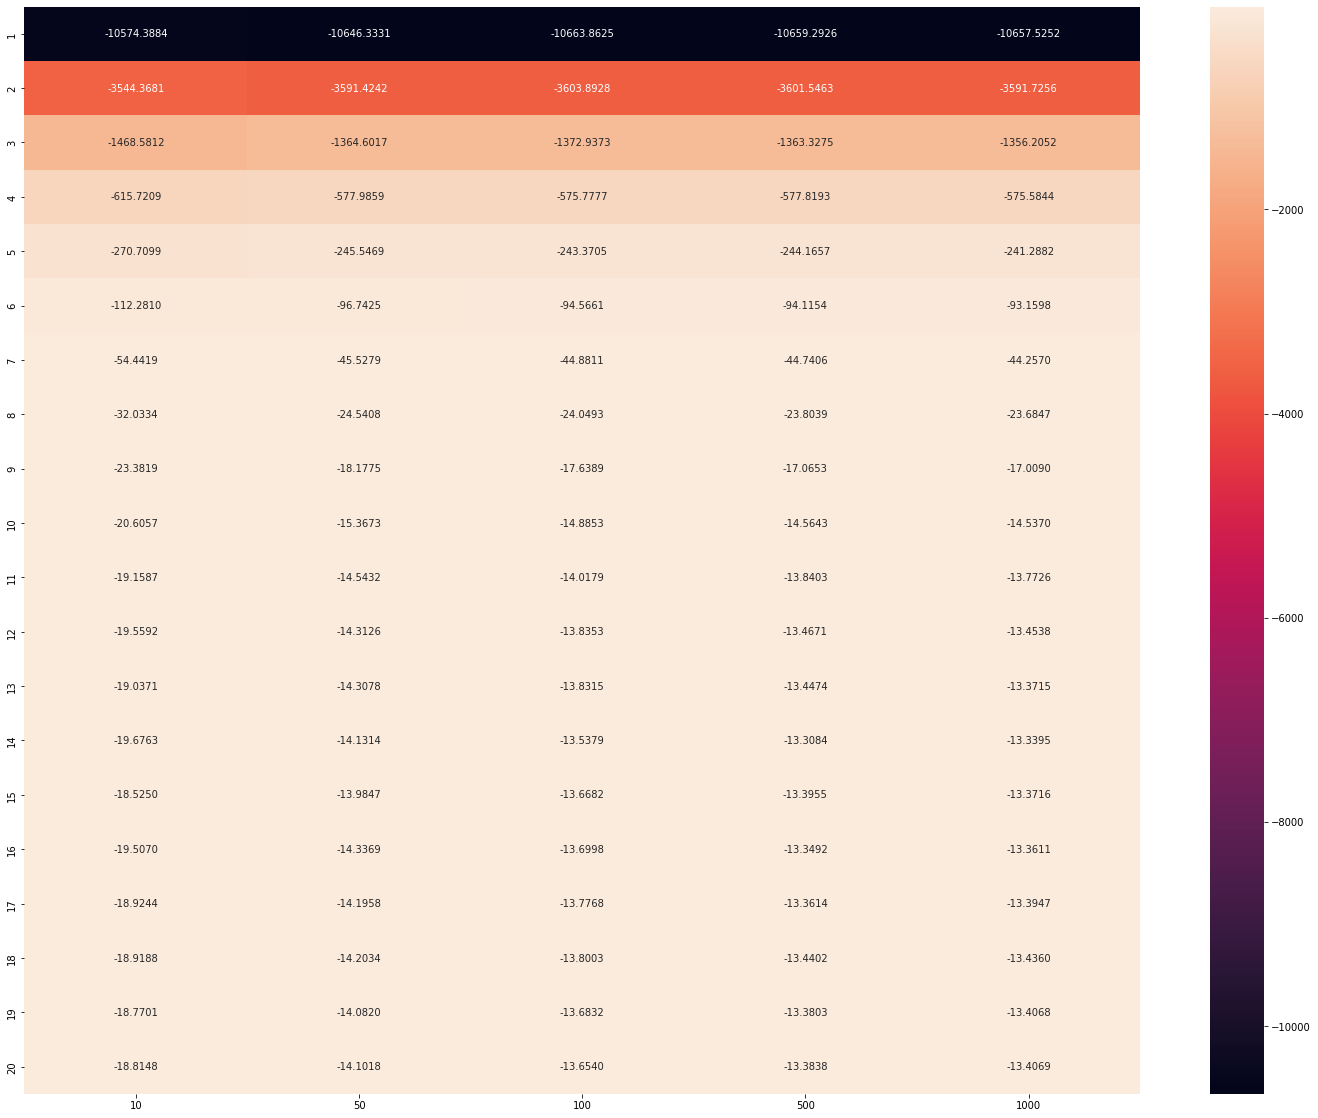

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(25, 20))
sns.heatmap(scores, annot=True, fmt='.4f')
plt.show()

### 최종모델
* RandomForest
    * n_estimators=500
    * max_depth=14

In [21]:
model = RandomForestRegressor(n_estimators=500, max_depth=14, random_state=0, n_jobs=-1)
model.fit(X_trainval, y_trainval)

RandomForestRegressor(max_depth=14, n_estimators=500, n_jobs=-1, random_state=0)

In [22]:
y_pred = model.predict(X_test)
score = mean_squared_log_error(y_test, y_pred, squared=False)
score

0.011534810443070968